In [9]:
# imports
from datamodel import OrderDepth, UserId, TradingState, Order, Observation, ConversionObservation
from typing import List, Dict, Tuple, Any
import string
import jsonpickle
import numpy as np
import math
from math import log, sqrt, exp
from statistics import NormalDist
import random
import pandas as pd
from io import StringIO


In [10]:
def parse_logs(file_path: str) -> Tuple[str, pd.DataFrame, List[Any]]:
    # Read entire log file
    with open(file_path, 'r') as f:
        content = f.read()

    # --- Parse Sandbox Logs ---
    sandbox_start = content.find('Sandbox logs:')
    activities_start = content.find('Activities log:')
    sandbox_section = content[sandbox_start + len('Sandbox logs:'):activities_start].strip()

    # --- Parse Activities Log ---
    trades_start = content.find('Trade History:')
    activities_section = content[activities_start + len('Activities log:'):trades_start].strip()

    # Read CSV section into a DataFrame
    activities_df = pd.read_csv(StringIO(activities_section), sep=';')

    # --- Parse Trades ---
    trades_section = content[trades_start + len('Trade History:'):].strip()
    trades_data = json.loads(trades_section)

    # Convert to Trade objects
    trades: List[Any] = [Trade(**t) for t in trades_data]

    return sandbox_section, activities_df, trades


In [30]:
products = [
    "RAINFOREST_RESIN",
    "KELP", "SQUID_INK",
    "CROISSANTS", "JAMS",
    "DJEMBES", "PICNIC_BASKET1",
    "PICNIC_BASKET2",
    "VOLCANIC_ROCK",
    "VOLCANIC_ROCK_VOUCHER_9500", "VOLCANIC_ROCK_VOUCHER_9750",
    "VOLCANIC_ROCK_VOUCHER_10000", "VOLCANIC_ROCK_VOUCHER_10250",
    "VOLCANIC_ROCK_VOUCHER_10500", "MAGNIFICENT_MACARONS"
]

In [31]:
csv_file_path_dict = {
    day: {"order_book": "", "trades": ""} for day in range(-2, 5)
}

### ORDER BOOK
csv_file_path_dict[-2]["order_book"] = "/Users/vasudev/Desktop/Projects/imc_prosperity/prosperity-imc25/rounds/round1/round-1-island-data-bottle/prices_round_1_day_-2.csv"
csv_file_path_dict[-1]["order_book"] = "/Users/vasudev/Desktop/Projects/imc_prosperity/prosperity-imc25/rounds/round2/eda/round-2-island-data-bottle/prices_round_2_day_-1.csv"
csv_file_path_dict[0]["order_book"] = "/Users/vasudev/Desktop/Projects/imc_prosperity/prosperity-imc25/rounds/round3/eda/round-3-island-data-bottle/prices_round_3_day_0.csv"
csv_file_path_dict[1]["order_book"] = "/Users/vasudev/Desktop/Projects/imc_prosperity/prosperity-imc25/rounds/round4/eda/round-4-island-data-bottle/prices_round_4_day_1.csv"
csv_file_path_dict[2]["order_book"] = "/Users/vasudev/Desktop/Projects/imc_prosperity/prosperity-imc25/rounds/round4/eda/round-4-island-data-bottle/prices_round_4_day_2.csv"
csv_file_path_dict[3]["order_book"] = "/Users/vasudev/Desktop/Projects/imc_prosperity/prosperity-imc25/rounds/round4/eda/round-4-island-data-bottle/prices_round_4_day_3.csv"
csv_file_path_dict[4]["order_book"] = "/Users/vasudev/Desktop/Projects/imc_prosperity/prosperity-imc25/rounds/round4/eda/activities_df.csv"

### TRADES
csv_file_path_dict[-2]["trades"] = "/Users/vasudev/Desktop/Projects/imc_prosperity/prosperity-imc25/rounds/round1/round-1-island-data-bottle/trades_round_1_day_-2.csv"
csv_file_path_dict[-1]["trades"] = "/Users/vasudev/Desktop/Projects/imc_prosperity/prosperity-imc25/rounds/round2/eda/round-2-island-data-bottle/trades_round_2_day_-1.csv"
csv_file_path_dict[0]["trades"] = "/Users/vasudev/Desktop/Projects/imc_prosperity/prosperity-imc25/rounds/round3/eda/round-3-island-data-bottle/trades_round_3_day_0.csv"
csv_file_path_dict[1]["trades"] = "/Users/vasudev/Desktop/Projects/imc_prosperity/prosperity-imc25/rounds/round4/eda/round-4-island-data-bottle/trades_round_4_day_1.csv"
csv_file_path_dict[2]["trades"] = "/Users/vasudev/Desktop/Projects/imc_prosperity/prosperity-imc25/rounds/round4/eda/round-4-island-data-bottle/trades_round_4_day_2.csv"
csv_file_path_dict[3]["trades"] = "/Users/vasudev/Desktop/Projects/imc_prosperity/prosperity-imc25/rounds/round4/eda/round-4-island-data-bottle/trades_round_4_day_3.csv"
csv_file_path_dict[4]["trades"] = "/Users/vasudev/Desktop/Projects/imc_prosperity/prosperity-imc25/rounds/round4/eda/bot_trades.csv"

In [ ]:
master_order_book_df = pd.DataFrame()
master_trades_df = pd.DataFrame()

for day in range(-2, 5):
    order_book_df = pd.read_csv(csv_file_path_dict[day]["order_book"], sep=';')
    trades_df = pd.read_csv(csv_file_path_dict[day]["trades"], sep=';')

    # Append to master DataFrame
    master_order_book_df = pd.concat([master_order_book_df, order_book_df])
    master_trades_df = pd.concat([master_trades_df, trades_df])

# check length of master_order_book_df and master_trades_df
print("Length of master_order_book_df:", len(master_order_book_df))
print("Length of master_trades_df:", len(master_trades_df))

# set pnl to 0
master_order_book_df['pnl'] = 0
master_order_book_df['pnl'] = master_order_book_df['pnl'].astype(float)

# save to csv
master_order_book_df.to_csv("master_order_book_df.csv", index=False)
master_trades_df.to_csv("master_trades_df.csv", index=False)

Length of master_order_book_df: 850000
Length of master_trades_df: 107654


# PRODUCT DICT

In [40]:
# create a dict with product as key and dict for value
# which has order_book and trades as keys and values as dataframes

product_dict = {
    product: {
        "order_book": master_order_book_df[master_order_book_df['product'] == product],
        "trades": master_trades_df[master_trades_df['symbol'] == product]
    }
    for product in products
}
# check length of product_dict
print("Length of product_dict:", len(product_dict))

Length of product_dict: 15


# MIDPRICE

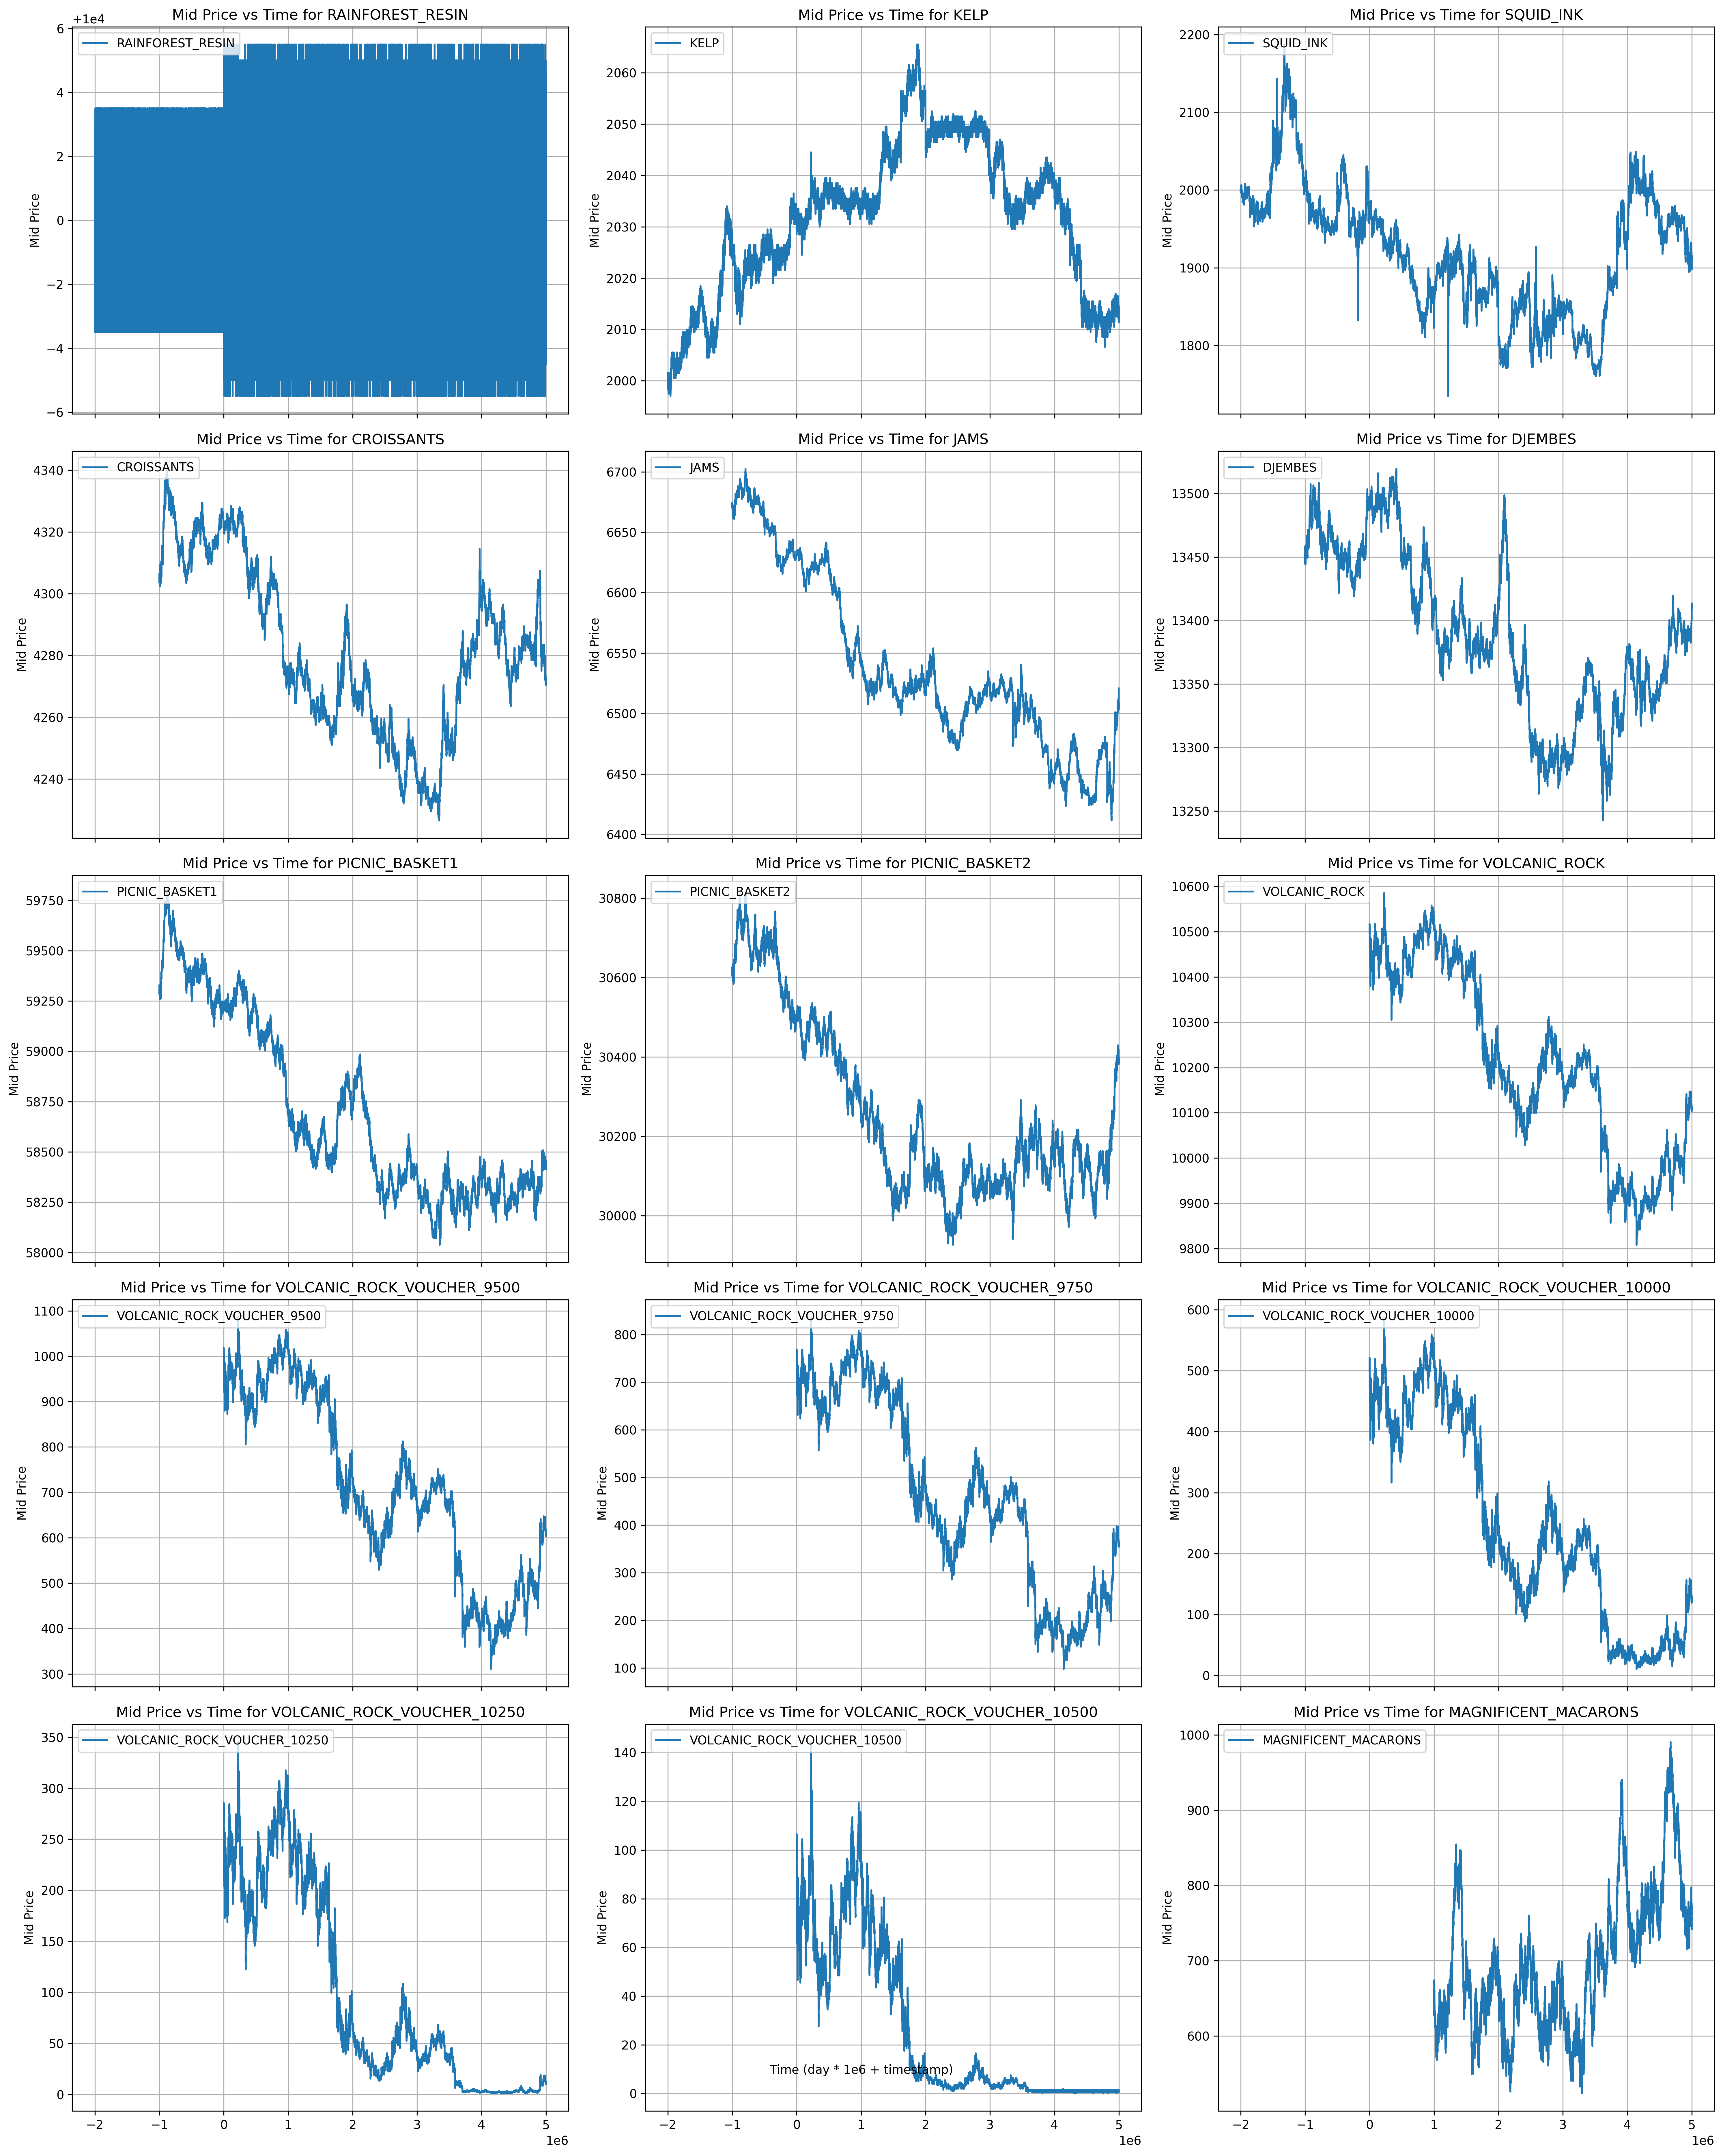

In [ ]:
# Create a figure with subplots in a grid layout
grid_rows = 5  # Number of rows in the grid
grid_cols = 3  # Number of columns in the grid
fig, axes = plt.subplots(nrows=grid_rows, ncols=grid_cols, figsize=(20, 5 * grid_rows), sharex=True, dpi=300)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop over all products and plot in subplots
for i, product in enumerate(products):
    order_book = product_dict[product]['order_book']
    
    # Calculate x-axis values
    x_values = order_book['day'] * 1e6 + order_book['timestamp']
    
    # Plot mid-price
    axes[i].plot(x_values, order_book['mid_price'], label=f'{product}')
    axes[i].set_title(f'Mid Price vs Time for {product}')
    axes[i].set_ylabel('Mid Price')
    axes[i].grid(True)
    axes[i].legend(loc='upper left')

# Hide any unused subplots
for j in range(len(products), len(axes)):
    fig.delaxes(axes[j])

# Set common x-axis label
fig.text(0.5, 0.04, 'Time (day * 1e6 + timestamp)', ha='center')

# Adjust layout
plt.tight_layout()
plt.show()